### HTML Parsing

In this notebook I will parse the data from 40,000+ AUR packages with beautifulsoup and put the data into a pandas DataFrame. 

In [2]:
from selenium import webdriver
import re
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import requests
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
import networkx

In [ ]:
def get_package_from_link(link):
    if link[-1] == "/":
        link = link[:-1]
    link = link.split("=")[-1]
    link = link.split("/")[-1]
    return link

pkg_dict_list = []
comments_dict_list = []

err_count = 0
err_files = []
os.chdir('../html/pkgs/')
for _, file in enumerate(os.listdir()):
    print(_, end=" ")
    if file != 'ghostdriver.log':
        f = open(file, 'r')
        html = f.read()
        b = BeautifulSoup(html, 'lxml')
        try:
            print(_)
            
            # attributes
            pkginfo = b.find('table', attrs={'id':'pkginfo'}).find_all('tr')
            
            attr_dict = {}
            for attribute in pkginfo:
                label = attribute.find('th').text.strip(": ")
                value = attribute.find('td').text
                value = value.replace('\\n', '\n')
                value = value.replace('\\t', '\t')
                value = re.sub('[\t+]', '', value)
                value = re.sub('[\n+]', '', value)
                attr_dict[label] = value

            dependencies = []
            pkgdeps = b.find('ul', attrs={'id':'pkgdepslist'})
            if pkgdeps:
                for p in pkgdeps.find_all('li'):
                    for link in p.find_all('a'):
                        dependencies.append(link['href'])
                dependencies = list(set([get_package_from_link(d) for d in dependencies]))
            attr_dict['pkgdeps'] = dependencies

            requirements = []
            pkgreqs = b.find('ul', attrs={'id':'pkgreqslist'})
            if pkgreqs:
                for p in pkgreqs.find_all('li'):
                    for link in p.find_all('a'):
                        requirements.append(link['href'])
                requirements = list(set([get_package_from_link(d) for d in requirements]))
            attr_dict['pkgreqs'] = requirements
            
            pkg_dict_list.append(attr_dict)
            
        except: 
            err_count += 1
            err_files.append(file)
            print("ERROR")
            print(err_count)
            print(file)
        b.decompose()
        f.close()
        

In [9]:
df = pd.DataFrame(pkg_dict_list)
df.to_csv('../csv/aur_package_data.csv')

In [3]:
df = pd.read_csv('../csv/aur_package_data.csv')

In [4]:
df.sample()

,Unnamed: 0,Conflicts,Description,First Submitted,Git Clone URL,Groups,Keywords,Last Packager,Last Updated,Licenses,Maintainer,Package Base,Popularity,Provides,Replaces,Submitter,Upstream URL,Votes,pkgdeps,pkgreqs
14633,14633,NaN,EDB (Evan's Debugger) is a binary mode debugge...,2015-10-12 01:26,https://aur.archlinux.org/edb-debugger-git.git...,NaN,NaN,maz-1,2015-10-12 02:42,GPL2,maz-1,edb-debugger-git,0.754601,NaN,NaN,maz-1,http://www.codef00.com/projects#debugger,2,"['capstone', 'qt5-base', 'qt5-xmlpatterns', 'b...",[]


### Cumulative count of AUR Packages 

Let's take a look at the cumulative count of AUR packages to see how the community has grown since it came into existence. 

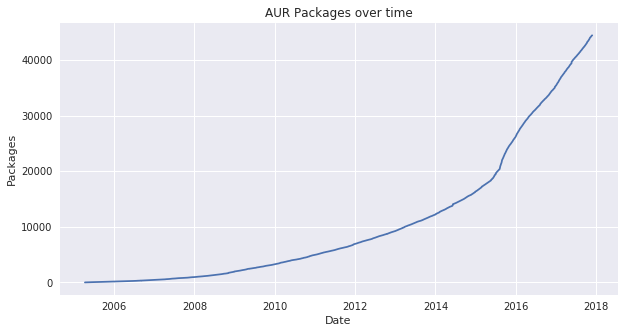

In [10]:
sns.set()
df = df[df['First Submitted'].notnull()]
df["First Submitted"] = pd.to_datetime(df['First Submitted'])
list_of_dates = df["First Submitted"].sort_values()
counts = np.arange(0, len(list_of_dates))
plt.figure(figsize=(10, 5))
_ = plt.plot(list_of_dates, counts)
_ = plt.title('AUR Packages over time')
_ = plt.xlabel('Date')
_ = plt.ylabel('Packages')
plt.savefig('/home/brian/Documents/github/briancaffey.github.io/static/aur_packages.png')

## Download Size vs Install Size

In [11]:
df.columns

Index(['Unnamed: 0', 'Conflicts', 'Description', 'First Submitted',
       'Git Clone URL', 'Groups', 'Keywords', 'Last Packager', 'Last Updated',
       'Licenses', 'Maintainer', 'Package Base', 'Popularity', 'Provides',
       'Replaces', 'Submitter', 'Upstream URL', 'Votes', 'pkgdeps', 'pkgreqs'],
      dtype='object')